In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
from water_pollution.data.preproc import *
from water_pollution.data import stations
from water_pollution.data import weather

from water_pollution.data import visu

In [4]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,25))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [5]:
# Builds the small training df (from saone data between 2011-2021)
file_path = '../../raw_data/pc_saone_2011_2021/Analyses.CSV'
rawdf = get_rawdf_from_file(file_path)
da_df = build_saone_base_training_data(rawdf)

In [6]:
stationsdf = stations.get_saone_stations_df()
# stationsdf.sort_values('alt')

In [7]:
from tensorflow.keras import models, layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

2021-12-03 13:46:55.113880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 13:46:55.113906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [74]:
##### RESTART POINT
df = da_df.copy()

mean_nitrate = df.groupby('station_id',as_index=False).mean()[['station_id','nitrate']]
mean_nitrate.columns = ['station_id','mean_station']

df_with_mean = pd.merge(df,mean_nitrate,on='station_id',how='left')
df = df_with_mean

tempdf = weather.get_saone_weather_df(window_size=40,delta=15) # TEMPERATURE
tempdf = tempdf[['date','temp','station_id']]

precdf = weather.get_saone_weather_df(window_size=35,delta=15) # PRECIPITATION
precdf = precdf[['date','precipitation','station_id']]


df = pd.merge(df,tempdf,on=['date','station_id'],how='left')
df = df.dropna()
df = pd.merge(df,precdf,on=['date','station_id'],how='left')
df = df.dropna()

# VAL SPLIT
df_val = df[df['station_id'] == 6005500].copy()
df = df[df['station_id'] != 6005500].copy()

# TRAIN / TEST SPLIT

feature_cols = [
    'sin_doy',
    'cos_doy',
    'mean_station',
    'precipitation',
    'temp',
    # 'source_dist',
    # 'year'
]

# Train / test / val
X = df[feature_cols]
y = df['nitrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)#,random_state=1)

X_val = df_val[feature_cols]
y_val=df_val['nitrate']

# PREPROCESSING

# Fit on X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all the X
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

def init_model(X):
    
    regl2 = regularizers.L2(0.001)
    
    model = models.Sequential()
    
    model.add( layers.Dense(30,activation='relu',input_dim=X.shape[1]) )
    #model.add( layers.Dropout(rate=0.1) )
    model.add( layers.Dense(30,activation='relu',kernel_regularizer=regl2) )
    #model.add(layers.Dropout(rate=0.2))
    
    model.add( layers.Dense(20,activation='relu',kernel_regularizer=regl2) )
    #model.add(layers.Dropout(rate=0.6))
    
    model.add(layers.Dense(1,activation='linear'))
    
    return model

model = init_model(X)
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(
	patience=10,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,  # set it to a large value, early stoping will stop the fit
	batch_size=16, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=0
)

min(history.history['val_loss'])

7.320646286010742

In [75]:
y_pred = model.predict(X_val)
df_val['prediction'] = y_pred

In [76]:
plotdf = df_val[df_val['date'] >= datetime.strptime('2017-01-01', '%Y-%m-%d')].sort_values('date')

In [77]:
plotdf['nitrate'].mean()

10.20263157894737

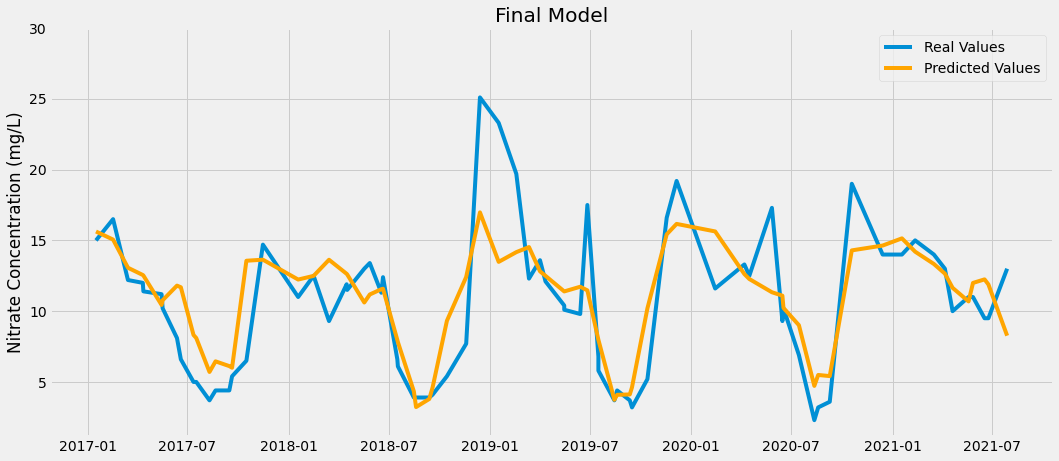

In [78]:

with plt.style.context('fivethirtyeight'):

    plotdf.sort_values('date',inplace=True)
    
    plt.figure(figsize=(16,7))
    plt.ylabel('Nitrate Concentration (mg/L)')
    plt.title('Final Model')

    plt.plot(plotdf['date'],plotdf['nitrate'],label='Real Values',linewidth=4)
    plt.plot(plotdf['date'],plotdf['prediction'],label='Predicted Values',color='orange',linewidth=4)
    plt.legend()
    
    plt.ylim(top=30)
    
    plt.savefig('model_2.png',dpi=150)    
    plt.show()

<Figure size 432x288 with 0 Axes>